In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    AutoConfig,
    AutoModel,
    pipeline
)
from datasets import Dataset
from evaluate import load

In [ ]:
MODEL_PATH = r'model\pretrained_DistilRoberta' #Path to the best performing model

In [20]:
test_data = pd.read_csv("test_data_detoxified.csv")
toxic_texts = test_data[test_data['class'] == 1]
original_texts = toxic_texts[['tweet','class']]
detoxified_texts = toxic_texts[['detoxified_text','class']]

In [ ]:
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

embeddings_orig = model.encode(original_texts['tweet'].to_numpy())
embeddings_detox = model.encode(detoxified_texts['detoxified_text'].to_numpy())

similarities = model.similarity(embeddings_orig, embeddings_detox)
similarity_scores = similarities.diag()

# Store similarity scores in the DataFrame
toxic_texts["labse_similarity"] = similarity_scores

<All keys matched successfully>
C:\Users\arham\AppData\Local\Temp\ipykernel_40984\958033613.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxic_texts["labse_similarity"] = similarity_scores


In [22]:
toxic_texts['labse_similarity'].describe()

count    2062.000000
mean        0.892247
std         0.087376
min         0.350106
25%         0.850473
50%         0.914038
75%         0.955754
max         1.000000
Name: labse_similarity, dtype: float64

<Axes: >

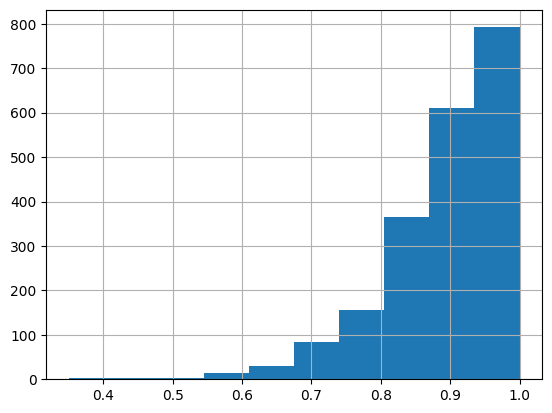

In [23]:
toxic_texts['labse_similarity'].hist()

<Axes: >

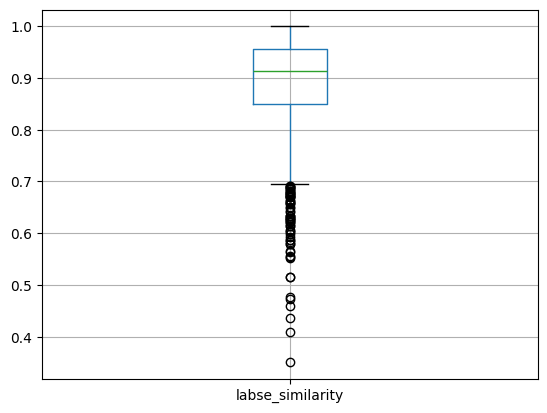

In [24]:
toxic_texts[['labse_similarity']].boxplot()

In [25]:
toxic_texts.sort_values(ascending=True,by='labse_similarity')[['tweet','detoxified_text']]


,tweet,detoxified_text
644,LRG ass nigguh,I don't like you.
69,Fucken pussy,I don't like you.
1415,GTFOH u bitch ass ref,You are not a good person
1288,RT @Xnastyy: no i ain't no bitch &amp; no i ai...,I am not a bad person.
1486,Fuck off bitch,Don't bother me
...,...,...
2445,My wigga... http://t.co/1pbGYaoW3N,My wigga... http://t.co/1pbGYaoW3N
348,the bae gettin her nips pierced &#128525;&#128...,the bae gettin her nips pierced &#128525;&#128...
1783,Work out hoe http://t.co/zOLMGuj5HK,work out hoe http://t.co/zOLMGuj5HK
1761,Ayee hoe,Ayee hoe


In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('distilroberta-base')
model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH)

pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-classification"
)

# Run detoxified texts through model
ds = Dataset.from_pandas(detoxified_texts[['detoxified_text']])
ds = ds.rename_column("detoxified_text", "text")

results = pipeline(detoxified_texts['detoxified_text'].to_list())

labels = [result['label'] for result in results]
scores = [result['score'] for result in results]

df = pd.DataFrame(results)
df.head()

Device set to use cuda:0


In [30]:
df['label'].value_counts()

label
not_offensive    1469
offensive         593
Name: count, dtype: int64

In [31]:
df.groupby('label').mean()

,score
label,
not_offensive,0.896978
offensive,0.896310


In [32]:
df.groupby('label').describe()

score                                                    \
                count      mean       std       min       25%       50%   
label                                                                     
not_offensive  1469.0  0.896978  0.042629  0.523505  0.900014  0.906814   
offensive       593.0  0.896310  0.127377  0.504708  0.800126  0.990630   

                                   
                    75%       max  
label                              
not_offensive  0.910513  0.926186  
offensive      0.996652  0.996717

<Axes: title={'center': 'score'}, xlabel='[label]'>

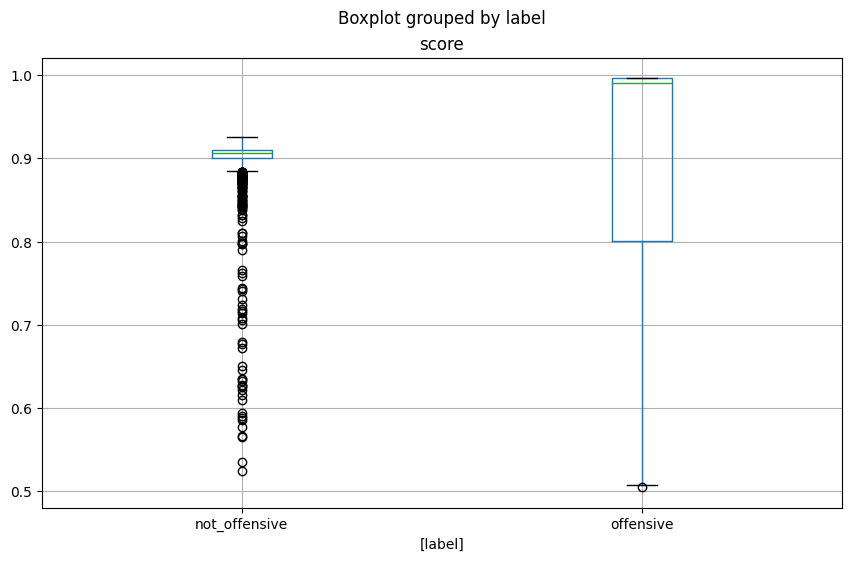

In [33]:
df.boxplot(by='label', figsize=(10, 6))

In [ ]:
bertscore = load("bertscore")

predictions = original_texts['tweet'].to_list()
references = detoxified_texts['detoxified_text'].to_list()

results = bertscore.compute(predictions=predictions, references=references, lang="en")

print(results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\arham\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arham\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9845702648162842, 0.9971679449081421, 0.9696931838989258, 0.8398333787918091, 0.8973515033721924, 0.9778203368186951, 0.9717157483100891, 0.97919762134552, 0.9812429547309875, 0.9606553316116333, 0.9636526107788086, 0.9040998816490173, 0.7216166853904724, 0.9904310703277588, 0.9424737095832825, 0.8257132768630981, 0.9589911699295044, 0.8486561179161072, 0.9493197202682495, 0.9756608009338379, 1.0, 0.978808581829071, 0.9612512588500977, 0.893808126449585, 0.9654634594917297, 0.9621443748474121, 0.9549753665924072, 0.9363808035850525, 0.9764527678489685, 0.965278148651123, 0.8935830593109131, 0.8549634218215942, 0.9871252775192261, 0.9604880809783936, 0.941195011138916, 0.9898111820220947, 0.9723348617553711, 0.935411810874939, 0.9600769281387329, 0.8774550557136536, 0.887042760848999, 0.9905974864959717, 0.8611650466918945, 0.9871160984039307, 0.8962039351463318, 0.962274432182312, 0.9555381536483765, 0.9156954884529114, 0.9253360033035278, 0.9502419233322144, 0.8274599

In [37]:
bertscore_df = pd.DataFrame(results)
bertscore_df = bertscore_df.drop(columns=['hashcode'])
bertscore_df.head()

,precision,recall,f1
0,0.984570,0.991239,0.987893
1,0.997168,0.997168,0.997168
2,0.969693,0.977179,0.973422
3,0.839833,0.968801,0.899719
4,0.897352,0.929181,0.912989


In [38]:
# Get average precision, recall, f1-score
bertscore_df.mean()

precision    0.930367
recall       0.969761
f1           0.948971
dtype: float64